## Vehicel tracking

### 1. Feature extraction

Extract features from an image. We mainly focused on the HOG (Histogram of Oriented Gradient) and the color feature.

In [22]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.feature import hog

#### 1.1 HOG feature

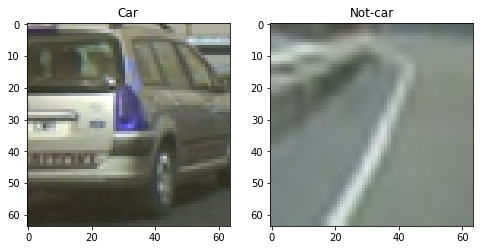

In [23]:
# Read a vehicle and non-vehicle image
vehicle_img = cv2.imread('vehicles/GTI_Left/image0168.png')
non_vehicle_img = cv2.imread('non-vehicles/GTI/image168.png')

fig = plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.title('Car')
plt.imshow(vehicle_img)
plt.subplot(122)
plt.title('Not-car')
plt.imshow(non_vehicle_img)
plt.show()

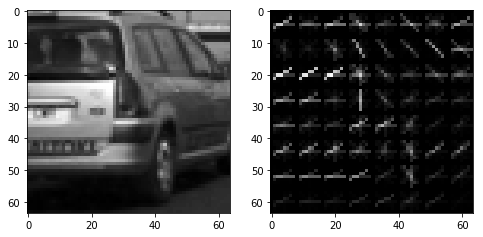

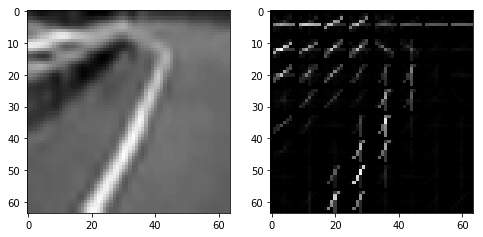

In [40]:
# Convert image to grayscale and get HOG feature
def cvt_cspace(image, cspace='RGB'):
    if cspace == 'YCrCb':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    elif cspace == 'HSV':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif cspace == 'LUV':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif cspace == 'LAB':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    else:
        img = image
    return img

def disp_hog_feature(image):
    orient = 8
    pix_per_cell = 8
    cell_per_block = 2
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    features, hog_img = hog(gray, orientations=orient, 
                            pixels_per_cell = (pix_per_cell, pix_per_cell),
                            cells_per_block = (cell_per_block, cell_per_block),
                            block_norm = 'L2-Hys',
                            visualise = True,
                            transform_sqrt = True,
                            feature_vector = True)
    fig = plt.figure(figsize=(8,6))
    plt.subplot(121)
    plt.imshow(gray, cmap='gray')
    plt.subplot(122)
    plt.imshow(hog_img, cmap='gray')
    plt.show()   
    
def disp_color_feature():
    for i in range(img.shape[2]):
        channel = img[:,:,i]
    
disp_hog_feature(vehicle_img)
disp_hog_feature(non_vehicle_img)